# Сравнительный анализ двух методик поиска наиболее значимых предикторов регрессионной модели

Анализ главных компонент не всегда связан с преобразованием просранства объектов к сингулярному базису. Часто это просто выяснение того, какие из признаков оказывают влияние на целевую переменную, а какие не оказывают (или их влияние незначительно). При такой постановке вопроса мы не абстрагируемся от предметной области, а наоборот: стараемся работать так, чтобы наши результаты имели максимально простую и очевидную интерпретацию.

В этом исследовании мы сравниваем две такие методики: 1) основанную на попарных одномерных регрессиях типа признак-таргет, 2) основанную на коэффициентах моножественной линейной регресии, использующей сразу все признаки в качестве предикторов.

Полный текст исследования доступен [в формате pdf](paper.pdf).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn.linear_model as skl
import matplotlib.pyplot as plt

## Чтение и предварительная обработка данных

In [2]:
# Читаем
df_d = pd.read_csv('data/data.csv')
df_d

,Дата,Новые комментарии,Поделились,"Процент отметок ""Нравится"" (%)","Отметки ""Не нравится""","Отметки ""Нравится""",Отказались от подписки,Новые подписчики,Постоянные зрители,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,CTR для значков видео (%),Показы,Подписчики,Средний процент просмотра (%),Просмотры,Время просмотра (часы),Средняя продолжительность просмотра
0,2023-01-01,0.0,9.0,100.00,0.0,16.0,5.0,5.0,84.0,144.0,2.0833,228.0,4.25,5176.0,0.0,30.51,475.0,21.2038,0.044640
1,2022-12-31,0.0,1.0,100.00,0.0,4.0,1.0,1.0,48.0,60.0,1.6111,108.0,4.05,2222.0,0.0,19.52,174.0,5.4814,0.031502
2,2022-12-30,0.0,3.0,75.00,1.0,3.0,1.0,1.0,94.0,133.0,2.1586,227.0,5.27,5584.0,0.0,23.51,490.0,17.8182,0.036364
3,2022-12-29,1.0,10.0,100.00,0.0,8.0,2.0,1.0,128.0,231.0,1.8524,359.0,5.78,6759.0,-1.0,25.35,665.0,25.9174,0.038974
4,2022-12-28,0.0,4.0,85.71,2.0,12.0,3.0,7.0,166.0,362.0,1.8390,528.0,7.04,6736.0,4.0,21.72,971.0,35.3850,0.036442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2021-08-24,0.0,0.0,90.91,1.0,10.0,0.0,4.0,55.0,97.0,1.8882,152.0,3.99,3156.0,4.0,41.29,287.0,16.8233,0.058618
496,2021-08-23,0.0,0.0,85.71,1.0,6.0,4.0,4.0,47.0,89.0,2.2794,136.0,3.99,4359.0,0.0,40.61,310.0,17.3132,0.055849
497,2021-08-22,0.0,1.0,100.00,0.0,2.0,1.0,4.0,44.0,63.0,2.5701,107.0,4.00,4176.0,3.0,26.91,275.0,10.4130,0.037865
498,2021-08-21,1.0,0.0,66.67,2.0,4.0,2.0,3.0,46.0,69.0,1.9304,115.0,4.03,2976.0,1.0,33.30,222.0,10.5967,0.047733


In [3]:
# "Средняя продолжительность просмотра" выражается через "Время простотра" и "Просмотры"
df_d = df_d.drop(columns = ['Средняя продолжительность просмотра'])
df_d['Средняя продолжительность просмотра'] = df_d['Время просмотра (часы)']/df_d['Просмотры']

# Все пропуски заполняем нулями
df_d = df_d.fillna(0)

# Удаляем строковый признак "Дата"
df = df_d.drop(columns = ['Дата'])

# Нормируем данные
df = (df - df.mean())/df.std()
df

,Новые комментарии,Поделились,"Процент отметок ""Нравится"" (%)","Отметки ""Не нравится""","Отметки ""Нравится""",Отказались от подписки,Новые подписчики,Постоянные зрители,Новые зрители,Среднее число просмотров одним пользователем,Уникальные зрители,CTR для значков видео (%),Показы,Подписчики,Средний процент просмотра (%),Просмотры,Время просмотра (часы),Средняя продолжительность просмотра
0,-0.663746,0.313121,0.739514,-0.954659,-0.021384,0.438704,-0.437513,-0.998478,-1.274858,1.300033,-1.251495,-1.092182,-0.649770,-0.649099,1.071190,-1.092405,-0.941891,1.027174
1,-0.663746,-0.939364,0.739514,-0.954659,-1.231817,-0.394542,-1.587351,-1.454000,-1.760959,-0.842008,-1.753414,-1.264006,-1.293287,-0.649099,-1.989368,-1.811231,-1.880355,-1.891956
2,-0.663746,-0.626243,-1.609039,-0.192152,-1.332686,-0.394542,-1.587351,-0.871944,-1.338514,1.641617,-1.255677,-0.215880,-0.560889,-0.649099,-0.878210,-1.056583,-1.143977,-0.811749
3,0.521515,0.469682,0.739514,-0.954659,-0.828339,-0.186230,-1.587351,-0.441729,-0.771396,0.252601,-0.703566,0.222272,-0.304920,-0.828013,-0.365797,-0.638661,-0.660539,-0.231832
4,-0.663746,-0.469682,-0.602919,0.570355,-0.424862,0.022081,0.137406,0.039099,-0.013310,0.191815,0.003304,1.304763,-0.309930,0.066556,-1.376700,0.092105,-0.095421,-0.794386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.663746,-1.095925,-0.114420,-0.192152,-0.626601,-0.602853,-0.724973,-1.365426,-1.546843,0.415001,-1.569377,-1.315554,-1.089819,0.066556,4.073265,-1.541373,-1.203362,4.133157
496,-0.663746,-1.095925,-0.602919,-0.192152,-1.030078,0.230392,-0.724973,-1.466653,-1.593139,2.189602,-1.636300,-1.315554,-0.827750,-0.649099,3.883895,-1.486446,-1.174120,3.517938
497,-0.663746,-0.939364,0.739514,-0.954659,-1.433556,-0.394542,-0.724973,-1.504613,-1.743599,3.508305,-1.757597,-1.306962,-0.867616,-0.112358,0.068641,-1.570030,-1.585990,-0.478050
498,0.521515,-1.095925,-2.391576,0.570355,-1.231817,-0.186230,-1.012432,-1.479306,-1.708877,0.606433,-1.724135,-1.281189,-1.129031,-0.470185,1.848165,-1.696601,-1.575025,1.714513


## Алгоритм 1. Попарные одномерные регрессии признак-таргет

### Ранжирование признаков

In [4]:
target = 'Просмотры'

# Составляем список всех признаков, кроме таргета
cols = df.drop(columns = [target]).columns

# Для красоты (можно было бы и без этого, но так лучше видно) заводим датафрем, который индексируется этими признаками
d = pd.DataFrame(index = cols)

# В этот список будем записывать коэффициенты детерминации возникающих одномерных моделей
list_of_score = []

# Цикл по всем признакам, кроме таргета
for col in cols:
    
    # Левая и правая части регрессионной задачи
    X = df[col].to_numpy().reshape(-1, 1)
    y = df[target]
    
    # Модель
    model = skl.LinearRegression()
    model.fit(X, y)
    
    # Аппендим скр в список скоров
    list_of_score.append(model.score(X, y))

# Добавляем в датаврейм список скоров
d['score'] = list_of_score

# Упорядочиваем датафрейм
d.sort_values('score')

,score
"Процент отметок ""Нравится"" (%)",0.000026
Отказались от подписки,0.001135
Среднее число просмотров одним пользователем,0.005225
Средняя продолжительность просмотра,0.030673
Средний процент просмотра (%),0.070686
Новые комментарии,0.089768
Подписчики,0.098139
"Отметки ""Не нравится""",0.195296
Поделились,0.254338
Новые подписчики,0.302298


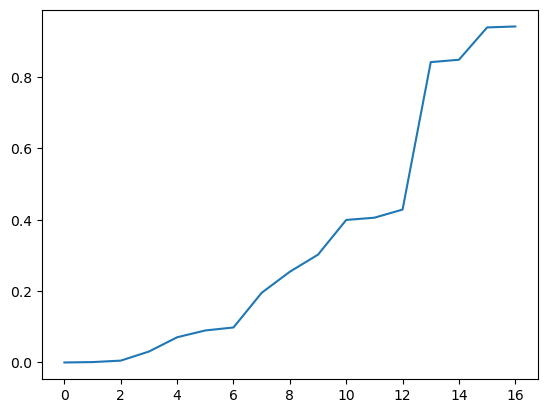

In [5]:
# Визуализируем упорядоченный список
plt.plot(d.sort_values('score')['score'].to_numpy(), '-')

В результате получился упорядоченный список признаков. И в этом порядке мы будем добавлять признаки в модель, увеличивая число предикторов, и получая все более и более точные модели.

### Добавление предикторов

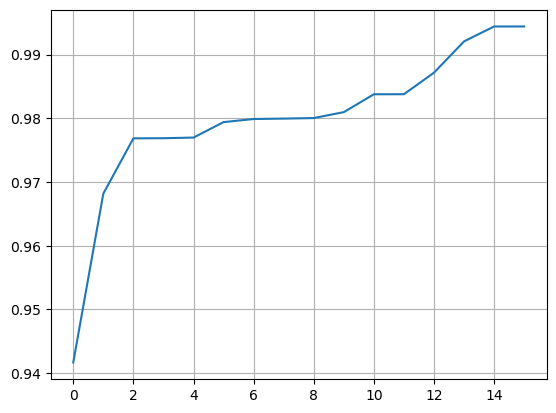

In [6]:
# Заводим упроядоченный список признаков
ordered_list_of_cols = d.sort_values('score').index

# Сюда будем аппендить оценки моделей
list_of_score = []

# Гоним цикл, одбавляя по одному признаку из упорядоченного списка
for i in np.arange(1, len(ordered_list_of_cols)):
    
    # Здесь берется срез упорядоченного списка
    X = df[ordered_list_of_cols[len(ordered_list_of_cols) - i:]]
    
    # Здесь мы должны учесть, что если модель одномерная, то левую часть нужно преобразовать в столбец
    if len(X.columns) == 1:
        X = X.to_numpy().reshape(-1, 1)
    else:
        X = X.to_numpy()
    y = df['Просмотры']
    
    # Фитим модель
    model = skl.LinearRegression()
    model.fit(X, y)
    
    # Аппендим скор
    list_of_score.append(model.score(X, y))

# Визуализируем, насколько быстро возрастает скор при добавлении предикторов
plt.plot(list_of_score, '-')
plt.grid()
plt.show()

После того, как мы прогоним второй алгоритм, мы сможем сравнить две картинки. Выиграет та кривая, которая быстрее растет.

## Алгоритм 2. Множественная регрессия на всех признаках и ее коэффициенты

Идея второго алгоритма в том, что мы будем считать наиболее значимыми те придикторы, коэффициенты при которых больше. Тогда мы тоже сможем отранжировать признаки по значимости и добавлять их в моднль по одному в проядке убывания значимости. И в результате получим еще одну кривую роста скора.

In [7]:
# Формируем левую и правую части
X = df.drop(columns = ['Просмотры']).to_numpy()
y = df['Просмотры'].to_numpy()

# Фитим модель
model = skl.LinearRegression()
model.fit(X, y)
model.score(X, y)
# Вызываем коэффициенты
model.coef_

# Заводим датафрейм для коэффициентов, чтобы посмотреть на них
df_T = pd.DataFrame(index = df.drop(columns = ['Просмотры']).columns)
df_T['coef'] = model.coef_

# Нас интересует абсолютная величина коэффициентов. Заводим и их
df_T['abs_coef'] = abs(df_T['coef'])

# Упорядочиваем по абсолютной величине
df_T.sort_values('abs_coef')

,coef,abs_coef
"Отметки ""Нравится""",3.232639e-03,3.232639e-03
Поделились,4.249498e-03,4.249498e-03
Новые комментарии,-4.296452e-03,4.296452e-03
Средний процент просмотра (%),1.016256e-02,1.016256e-02
CTR для значков видео (%),1.531514e-02,1.531514e-02
"Процент отметок ""Нравится"" (%)",-1.535508e-02,1.535508e-02
"Отметки ""Не нравится""",-2.607018e-02,2.607018e-02
Показы,5.437099e-02,5.437099e-02
Среднее число просмотров одним пользователем,8.637785e-02,8.637785e-02
Средняя продолжительность просмотра,-1.104168e-01,1.104168e-01


И оказывается, что мы рано радовались. Три последних признака дают какие-то астрономические коэффициенты, хотя это полный бред. Причина в эффекте мультиколлинеарности, подробнее об этом см. [статью](paper.pdf).

In [8]:
# Удаляем признаки, дающие эффект мультиколлинеарности и формируем данные для регрессии
X = df.drop(columns = ['Просмотры', 'Подписчики', 'Новые зрители']).to_numpy()
y = df['Просмотры'].to_numpy()

# Фитим
model = skl.LinearRegression()
model.fit(X, y)
model.score(X, y)
model.coef_

# Смотрим на коэффициенты. Теперь они нормальные
df_T = pd.DataFrame(index = df.drop(columns = ['Просмотры', 'Подписчики', 'Новые зрители']).columns)
df_T['coef'] = model.coef_
df_T['abs_coef'] = abs(df_T['coef'])
df_T.sort_values('abs_coef')

,coef,abs_coef
Новые подписчики,0.003072,0.003072
Новые комментарии,-0.003207,0.003207
Поделились,0.003887,0.003887
"Отметки ""Нравится""",0.004111,0.004111
Средний процент просмотра (%),0.008487,0.008487
CTR для значков видео (%),0.014451,0.014451
"Процент отметок ""Нравится"" (%)",-0.015613,0.015613
"Отметки ""Не нравится""",-0.025699,0.025699
Отказались от подписки,-0.025721,0.025721
Показы,0.052395,0.052395


### Добавление предикторов

In [9]:
# Заводим список, в каком порядке будем добавлять предикторы
ordered_list_of_cols = list(df_T.sort_values('abs_coef').index)

# Сюда будем аппендить оценки моделей
list_of_score_2 = []

# В цмкле по одному добавляем предикторы
for i in np.arange(1, len(ordered_list_of_cols)):
    
    # Здесь берем срез списка
    X = df[ordered_list_of_cols[len(ordered_list_of_cols) - i:]]
    
    # Проверяем условие одномерности
    if len(X.columns) == 1:
        X = X.to_numpy().reshape(-1, 1)
    else:
        X = X.to_numpy()
    y = df['Просмотры']
    
    # Фмтим модель
    model = skl.LinearRegression()
    model.fit(X, y)
    
    # Аппендим оценку
    list_of_score_2.append(model.score(X, y))

## Сравнение алгоритмов

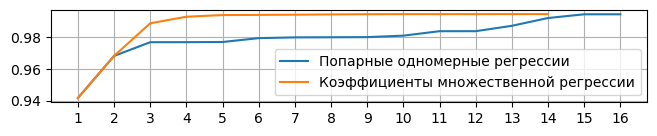

In [10]:
plt.figure(figsize = (7.7, 1.2))
plt.plot(np.arange(1, len(list_of_score) + 1), list_of_score, '-', label = 'Попарные одномерные регрессии')
plt.plot(np.arange(1, len(list_of_score_2) + 1), list_of_score_2, '-', label = 'Коэффициенты множественной регрессии')
plt.grid()
plt.xticks(np.arange(1, 17, 1))
plt.legend()
# plt.savefig('Сравнение алгоритмов.png', dpi = 300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

Желтая кривая выше.